In [1]:
from keras.applications import vgg19
from keras import backend as K
from keras_contrib.layers import InstanceNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from matplotlib.pyplot import imshow
from layers import AdaIN
from models import EncoderModel, DecoderModel, Vgg19TruncatedModel, LossModel
from utils import image_postprocess, NBatchLogger, list_images, preload_img
from debug import dump_model, display_layer
import numpy as np
from keras.datasets import cifar10

%matplotlib inline 

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
src_model = Vgg19TruncatedModel('block1_conv1')

encoder_model = EncoderModel(src_model)
encoder_output = encoder_model.outputs[0]

decoder_model = DecoderModel(src_model, encoder_output.shape.as_list())
decoder_output = decoder_model(encoder_output)

train_model = Model(inputs=encoder_model.inputs[0], outputs=decoder_output)

In [3]:
_ , (x, _) = cifar10.load_data()
x = vgg19.preprocess_input(x.astype('float32'))

#x = list_images("train2014", limit=128, shape=(256,256,3))
#x.shape

In [4]:
dump_model(train_model)
train_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
content_input_1 (InputLayer) (None, None, None, 3)     0         
_________________________________________________________________
content_block1_conv1 (Conv2D (None, None, None, 64)    1792      
_________________________________________________________________
content_block1_conv2 (Conv2D (None, None, None, 64)    36928     
_________________________________________________________________
content_block1_pool (MaxPool (None, None, None, 64)    0         
_________________________________________________________________
content_block2_conv1 (Conv2D (None, None, None, 128)   73856     
_________________________________________________________________
decoder_model (DecoderModel) (None, None, None, 3)     112451    
Total params: 225,027
Trainable params: 112,451
Non-trainable params: 112,576
________________________________________________________________

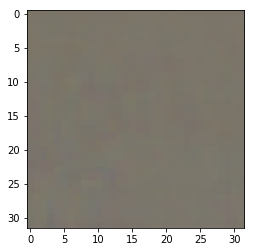

In [5]:
result = train_model.predict(x[:1])
imshow(image_postprocess(result[0]))

In [6]:
def content_loss(base, decoded_value):
    return K.mean(K.square(decoded_value - base), axis=-1)
train_model.compile(optimizer='adam', loss=content_loss)

In [7]:
train_model.fit(x, x, epochs=5, \
                  batch_size=128, shuffle=True, 
                  callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/5
10000/10000 [==============================] - 79s 8ms/step - loss: 713.3158
Epoch 2/5
10000/10000 [==============================] - 78s 8ms/step - loss: 244.5926
Epoch 3/5
10000/10000 [==============================] - 76s 8ms/step - loss: 202.8082
Epoch 4/5
10000/10000 [==============================] - 79s 8ms/step - loss: 173.4490
Epoch 5/5
10000/10000 [==============================] - 75s 8ms/step - loss: 159.3853


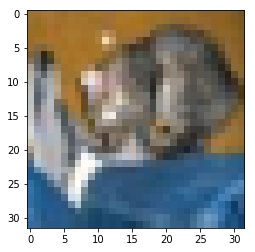

In [8]:
imshow(image_postprocess(x[0]))

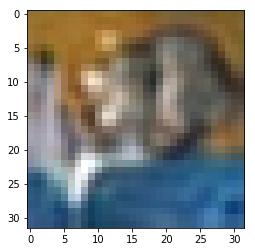

In [9]:
result = train_model.predict(x[:1])
imshow(image_postprocess(result[0]))

In [10]:
image = preload_img("paccots.jpg")
result = train_model.predict(image)

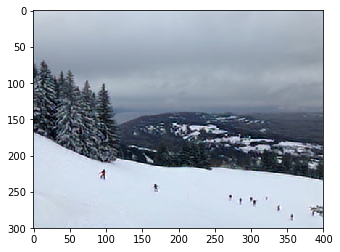

In [11]:
imshow(image_postprocess(result[0]))